In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import gaussian_kde as kde

import datetime
import dateutil.parser as parser
import time
import re
from difflib import SequenceMatcher
import pygsheets

try:
    from nltk.tokenize import sent_tokenize, word_tokenize 
except:
    !pip install -U nltk
    from nltk.tokenize import sent_tokenize, word_tokenize 
import warnings 
  
warnings.filterwarnings(action = 'ignore') 

from dateutil.parser import parse

# Working With Google Sheets API

This script was originally written to analyze incoming data
from a directory campaign I headed up as board member of 
Stanford in Entertainment - NYC. The Google Sheets API
is pretty darn powerful, and I've been able to effectively
run most of my databases entirely for free using a combination
of the PyGSheets library and my own code. Granted, for fast I/O,
other database implementations are much better - but if all you 
need if periodic analysis of human-time data, this works well.

In [2]:
'''Functions!'''
#Recursively flattens any nested list -
#useful if you aren't working with np arrays.
def flatten(S):
    if S == []:
        return S
    if isinstance(S[0], list):
        return flatten(S[0]) + flatten(S[1:])
    return S[:1] + flatten(S[1:])

#Calculates the peak of a KDE function two ways:
#1) Discrete: gets the value in the dataset closest 
#to the KDE peak, or
#2) Continuous: gets the peak at a certain resolution.
def kde_max(s, mode='discreet', resolution=1000):
    #Takes sequential float-castable data and returns the
    #value associated with the maximum density.
    c = s.name
    vals = s.apply(float).dropna()
    
    if mode=='discreet':
        density = vals.apply(kde(vals))\
                  .apply(lambda x: x[0])
        density.name = 'Density'

        peak = pd.concat([vals,density], axis=1)\
               .sort_values('Density', ascending=False)\
               .reset_index(drop=True).loc[0,c]
        return peak
    elif mode=='continuous':
        x = pd.Series(np.linspace(min(vals), max(vals), resolution))\
            .rename('x')
        y = x.apply(kde(vals)).rename('y').map(lambda x: x[0])
        peak = pd.concat([x,y], axis=1).sort_values('y', ascending=False)\
            .iloc[0]['x']
        return peak

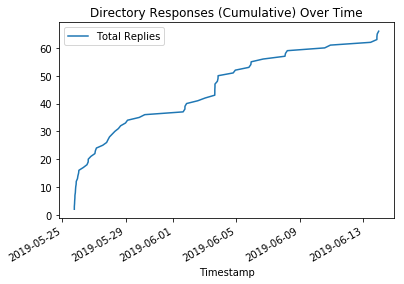

In [4]:
'''Loading and Processing!'''
#This block loads a Google Spreadsheet to a Pandas array.
#The data I'm working with is proprietary, so forgive the 
#workaround I used to get the URL and client secret.
gc = pygsheets.authorize(client_secret='../secret_stuff/client_secret.json')
url=''
with open('../secret_stuff/sie_directory_url.txt','r') as file:
    url = file.read()
name = 'Form Responses 1'
sheet = gc.open_by_url(url)
data = sheet.worksheet_by_title(name).get_as_df().dropna()

'''A couple lines to clean the data'''
#Only look at people who included their industry (this is a networking directory)
data = data[data['Industry'].str.len() > 1]
#Parse the timestamp to Datetime format
data['Timestamp'] = data['Timestamp'].apply(parse)
#Convert Graduation Year to floats
data['Graduation Year'] = data['Graduation Year'].convert_objects(convert_numeric=True)
#Eliminate people who put unrealistic grad years
#(Shout out to the guy who said they graduated in 7 BCE!)
data = data[data['Graduation Year']>(2019-127)]
#Order the data by entry date.
data = data.sort_values('Timestamp')

'''
This generates a figure showing cumulative responses over time;
this is useful for gauging responsivity.
'''
#Assign a value of 1 to each row
data['count_values'] = 1
#Cumulatively sum the afforementioned column
data['Total Replies'] = data['count_values'].cumsum()
#Plot it!
ax = data[1:].plot('Timestamp', 'Total Replies')
plt.title('Directory Responses (Cumulative) Over Time')
fig = ax.get_figure()

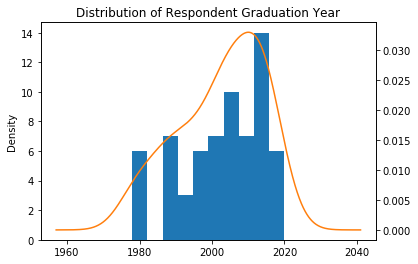

In [5]:
'''Show Grad Year Distribution'''
fig, ax1 = plt.subplots()
data['Graduation Year'].plot(kind='hist', ax=ax1)
data['Graduation Year'].plot(kind='kde', ax=ax1, secondary_y=True)
plt.title('Distribution of Respondent Graduation Year')
plt.show()

In [67]:
'''
On average, the respondent pool to the survey
graduated around the following year:
'''
kde_max(data['Graduation Year'])

2009.0

## Alumni Demographics can be fun!